In [23]:
# Função que recebe o grupo_produto e retorna a máscara

# calca|shorts: Pants
# blusa: Upper-clothes
# vestido: Dress
# saia: Skirt

def get_mask(group):
    if group == 'calca' or group == 'short':
        return 'Pants'
    elif group == 'blusa':
        return 'Upper-clothes'
    elif group == 'vestido':
        return 'Dress'
    elif group == 'saia':
        return 'Skirt'
    else:
        return 0


---

Função de Segmentação

In [ ]:
# Função para calcular e aplicar o bounding box
def get_cropped_bound_rect(image, mask, percent=10):
    if not isinstance(mask, np.ndarray):
        mask = np.array(mask)

    # Encontrando contornos
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        raise ValueError("Nenhum contorno encontrado na máscara.")
    
    # Selecionando o maior contorno
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Calculando epsilon como porcentagem da largura da imagem
    epsilon = int(image.shape[1] * (percent / 100))
    
    # Ajustando com o epsilon
    x = max(0, x - epsilon)
    y = max(0, y - epsilon)
    w = min(image.shape[1] - x, w + 2 * epsilon)
    h = min(image.shape[0] - y, h + 2 * epsilon)
    
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image, (x, y, w, h)

In [42]:
from PIL import Image, ImageChops
from transformers import pipeline
from matplotlib import pyplot as plt
import numpy as np
import cv2

def get_cropped_image_from_pil(image, group, pipe, percent=3):
    """
    Recebe uma imagem PIL carregada, um grupo, um modelo de segmentação (pipe) e retorna
    uma imagem recortada com base na máscara gerada pelo modelo.

    Parâmetros:
        image (PIL.Image): Imagem já carregada.
        group (str): Grupo do produto (ex.: 'Pants', 'Shirt', etc.).
        pipe (callable): Modelo de segmentação que retorna máscaras.
        percent (int, opcional): Margem percentual ao redor do bounding box. Padrão: 3.

    Retorno:
        tuple: Imagem recortada (NumPy array) e bounding box (x, y, w, h).
    """
    # Certificando-se de que a imagem está em modo RGB
    if image.mode != "RGB":
        image = image.convert("RGB")

    # Aplicando o modelo de segmentação
    results = pipe(image)

    # Obtendo a máscara do grupo especificado
    mask = [r["mask"] for r in results if r["label"] == group][0]

    # Multiplicando a máscara pela imagem original
    masked_image = ImageChops.multiply(image, mask.convert("RGB"))

    # Encontrando o bounding box baseado na máscara
    bbox = mask.getbbox()
    if bbox:
        masked_image = masked_image.crop(bbox)

    # Certificando-se de que as dimensões da máscara e da imagem original são consistentes
    if mask.size != image.size:
        mask = mask.resize(image.size)

    # Convertendo a máscara para NumPy
    mask_np = np.array(mask)
    mask_np = (mask_np > 0).astype(np.uint8)  # Garante que seja binária

    # Convertendo a imagem para NumPy
    original_img_np = np.array(image)
    original_img_np = cv2.cvtColor(original_img_np, cv2.COLOR_RGB2BGR)

    # Calculando o bounding box com ajuste baseado em porcentagem
    cropped_image, bounding_box = get_cropped_bound_rect(original_img_np, mask_np, percent=percent)

    return cropped_image, bounding_box


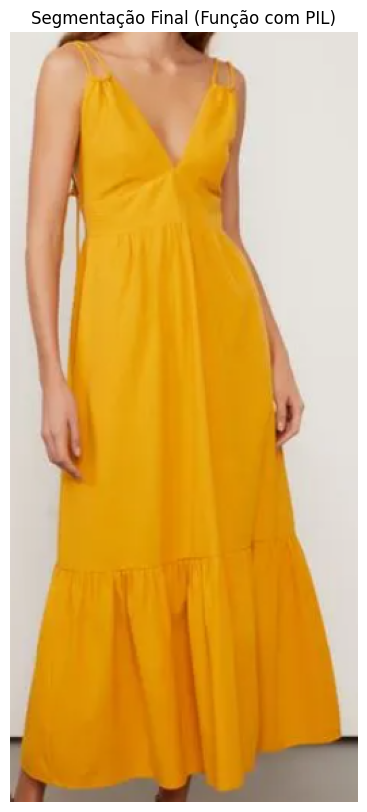

In [44]:
pipe = pipeline("image-segmentation", model="sayeed99/segformer_b3_clothes")
image = Image.open("../../TESTES E EXPERIMENTOS/teste_images_mod_2/V.png")
cropped_image, bounding_box = get_cropped_image_from_pil(image, get_mask('vestido'), pipe, percent=3)

# Plotando a imagem recortada
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Segmentação Final (Função com PIL)")
plt.show()

---